In [2]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
hbar = c.hbar
KB = c.Boltzmann

In [4]:
col = ['T','1/Q','1/Q_err']
data = pd.read_csv('data_20_02_set2_again.txt',delimiter='\t',usecols=col)

Let's look at the first resonance at different temperatures

In [11]:
indx = [i for (i,y) in enumerate(data['1/Q']) if (i%4==1)]
x = np.array(data['T'][indx])
y = np.array(data['1/Q'][indx])
err = np.array(data['1/Q_err'][indx])
print(err)

[1.50600482e-06 1.57772360e-06 1.55343351e-06 1.52545871e-06
 1.57035235e-06 1.59252014e-06 1.61211890e-06 1.62329894e-06
 1.70478544e-06 1.80212074e-06 1.91543921e-06 2.16068478e-06
 9.14319138e-07 1.54833337e-06 1.48611549e-06 1.54556173e-06
 1.55032116e-06]


Now data are unordered\
We have to order them by temperature T

In [12]:
sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
x = np.array([x[i] for i in sorted_indices])
y = np.array([y[i] for i in sorted_indices])
err = err[sorted_indices]

In [13]:
indices = [i for (i,y) in enumerate(y) if y>0]
x = np.array([x[i] for i in indices])
y = np.array([y[i] for i in indices])
err = err[indices]
                                    

In [14]:
indices = [i for (i,y) in enumerate(y) if y<1]
x = np.array([x[i] for i in indices])
y = np.array([y[i] for i in indices])
err = err[indices]

In [15]:
indices = [i for (i,x) in enumerate(x) if (x!=50)]
x = np.array([x[i] for i in indices])*1e-3
y = np.array([y[i] for i in indices])
err = err[indices]

Now that we have selected data (I think we hav eto justify the choises we made) we can plot them

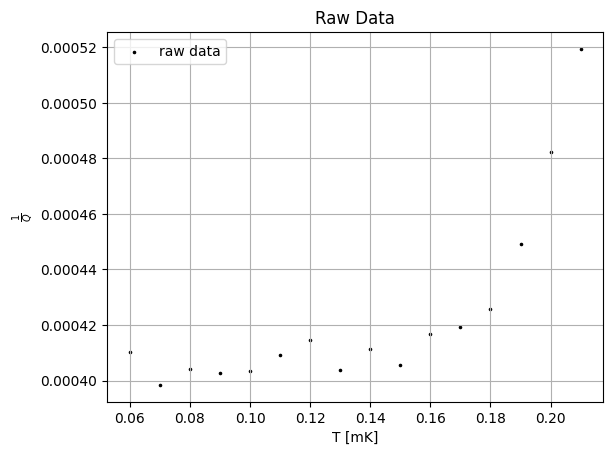

In [16]:
plt.scatter(x, y, s=10, marker='.', color='black', label='raw data')
plt.xlabel('T [mK]')
plt.ylabel(r'$\frac{1}{Q}$')
plt.legend()
plt.title('Raw Data')
plt.grid()

Let's estimate at the parameter $Q_{0}$

In [17]:
q0 = np.mean(y[np.where(x<0.12)[0]])
b= 1e-6
T_k = 30*1e-3
alpha = 0.5

In [18]:
def QT(T,d0):
    omega = 5*1e9
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0

def kondo(T,d0, b, T_k):
    omega = 5*1e11
    csi = (hbar * omega)/(2*KB*T)
    num = np.exp(-d0/(KB*T))*np.sinh(csi)*sp.kn(0,csi)
    den = np.pi*(1-2*np.exp(-d0/(KB*T))*np.exp(-csi)*sp.iv(0,-csi))
    return num/den * (alpha/2) + q0 - b*np.log(T/T_k)

Let's plot data and compare them with analytical models provided the forecasted parameters

In [26]:
d0 = 1.54*1e-23

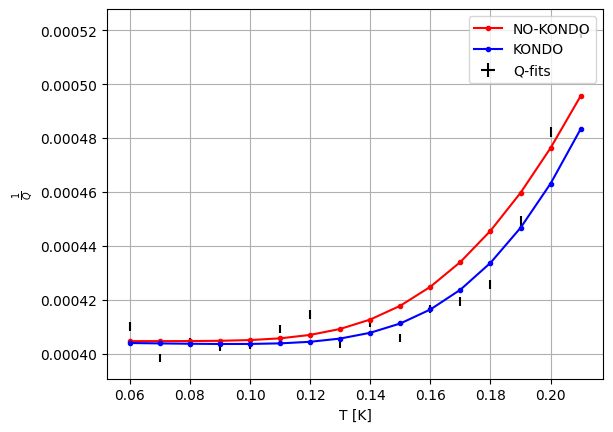

In [27]:
plt.errorbar(x, y, xerr=0, yerr=err, alpha=1, color='black', label='Q-fits', marker='.', fmt='none')
plt.plot(x, QT(x, d0), color='red', label='NO-KONDO', marker='.')
plt.plot(x, kondo(x, d0, b, T_k),  color='blue', label='KONDO', marker='.')
plt.xlabel('T [K]')
plt.ylabel(r'$\frac{1}{Q}$')
plt.legend()
plt.grid()

Now we can start to fit

In [28]:
#bounds = ([4.7*1e-23,4.7*1e-7,0.03],[4.75*1e-23,4.9*1e-7,0.5])
popt_nk,pcov_nk = curve_fit(QT, x, y, p0=[d0],sigma=err,maxfev=10000)
popt,pcov = curve_fit(kondo, x, y, p0=[d0,4.8e-7,0.035],sigma=err,maxfev=10000)#,bounds=bounds)

In [29]:
chi2 = 0
chi2_nk = 0
for i in range(len(y)):
    chi2 += ((y[i]-kondo(T=x[i],d0=popt[0],b=popt[1],T_k=popt[2]))/err[i])**2
    chi2_nk += ((y[i]-QT(T=x[i],d0=popt_nk[0]))/err[i])**2
chi2_0 = chi2/(len(x)-3)
chi2_0_nk = chi2_nk/(len(x)-1)
print(chi2_0)
print(chi2_0_nk)

23.0783519956423
35.016754376476925


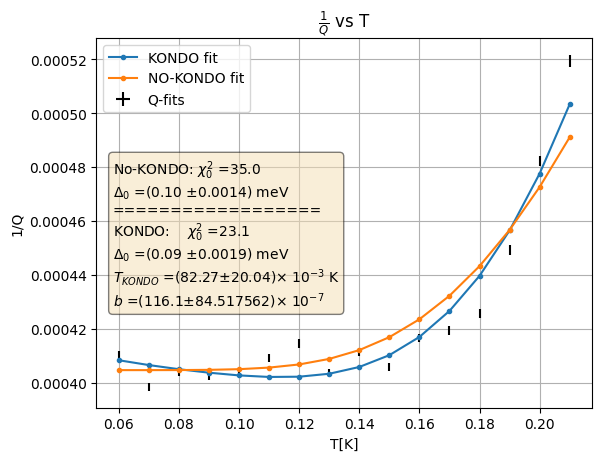

In [39]:
from matplotlib import lines as line
from matplotlib import colormaps as cmap
plt.errorbar(x,y,xerr=0,yerr=err,alpha=1, color='black',label='Q-fits',marker='.',fmt='none')
plt.plot(x,kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]),marker='.',label='KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.plot(x,QT(T=x,d0=popt_nk[0]),marker='.',label='NO-KONDO fit')#,label='KONDO-fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.ylabel('1/Q')
plt.xlabel('T[K]')
textstr = '\n'.join((
    r"No-KONDO: $\chi_{0}^2$ ="+f"{chi2_0_nk:.1f}",
    r"$\Delta_{0}$ ="+f"({popt_nk[0]/c.electron_volt*1e3:.2f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov_nk)[0])/c.electron_volt*1e3:.4f})"+" meV",
    r"==================",
    r"KONDO:    $\chi_{0}^2$ ="+f"{chi2_0:.1f}",
    r"$\Delta_{0}$ ="+f"({popt[0]/c.electron_volt*1e3:.2f} "+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[0])/c.electron_volt*1e3:.4f})"+" meV",
    r"$T_{KONDO}$ ="+f"({popt[2]*1e3:.2f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[2])*1e3:.2f})"+r"$\times$ $10^{-3}$"+" K",
    r"$b$ ="+f"({popt[1]*1e7:.1f}"+r"$\pm$"+f"{np.sqrt(np.diag(pcov)[1])*1e7:.6f})"+r"$\times$ $10^{-7}$")
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.058, 0.000483, textstr, fontsize=10,verticalalignment='top', bbox=props)
plt.legend(loc='upper left')
plt.title(r'$\frac{1}{Q}$ vs T')
plt.savefig('20_02_set2.png')
plt.grid()

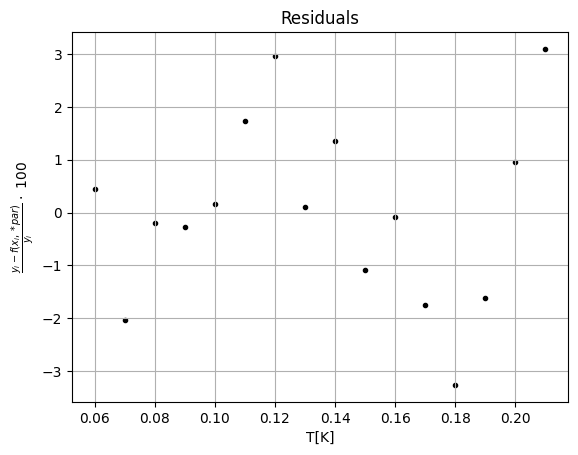

In [31]:
plt.scatter(x,(y-kondo(T=x,d0=popt[0],b=popt[1],T_k=popt[2]))/y * 100,marker='.',label='Residuals',color='black')
plt.xlabel('T[K]')
plt.title('Residuals')
plt.ylabel(r'$\frac{y_{i}-f(x_{i},*par)}{y_{i}}\cdot$ 100')
plt.grid()

In [37]:
print(2*popt[0]/3.5/c.Boltzmann)

0.6006788761314247
